In [8]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

## 1. CARGA Y PREPROCESAMIENTO DE DATOS 

In [9]:

base_dir = 'images'
target_size = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.6, 1.4],
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train = train_datagen.flow_from_directory(os.path.join(base_dir, 'train'), target_size=target_size, batch_size=32, class_mode='binary')
val = test_datagen.flow_from_directory(os.path.join(base_dir, 'validation'), target_size=target_size, batch_size=32, class_mode='binary')
test = test_datagen.flow_from_directory(os.path.join(base_dir, 'test'), target_size=target_size, batch_size=32, class_mode='binary', shuffle=False)

Found 1492 images belonging to 2 classes.
Found 106 images belonging to 2 classes.
Found 110 images belonging to 2 classes.


## 2. MODELO CON EfficientNetB0

In [29]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam  # Cambiado a Adam por compatibilidad
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Modelo base
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True
for layer in base_model.layers[:-50]:  # Descongelar más capas
    layer.trainable = False

# Arquitectura del modelo
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)  # Capa intermedia
x = Dropout(0.5)(x)  # Aumentar Dropout
outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)

# Compilación con optimizador corregido
model.compile(optimizer=Adam(learning_rate=1e-6), loss='binary_crossentropy', metrics=['accuracy'])

# Callback para ajustar el learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)

## 3. ENTRENAMIENTO 


In [30]:
history = model.fit(train, epochs=15, validation_data=val, callbacks=[reduce_lr])  

Epoch 1/15
47/47 [==============================] - 39s 776ms/step - loss: 0.7073 - accuracy: 0.5074 - val_loss: 0.7089 - val_accuracy: 0.4434 - lr: 1.0000e-06
Epoch 2/15
47/47 [==============================] - 37s 772ms/step - loss: 0.7006 - accuracy: 0.5174 - val_loss: 0.7073 - val_accuracy: 0.4434 - lr: 1.0000e-06
Epoch 3/15
47/47 [==============================] - 36s 754ms/step - loss: 0.7073 - accuracy: 0.5060 - val_loss: 0.7100 - val_accuracy: 0.4434 - lr: 1.0000e-06
Epoch 4/15
47/47 [==============================] - 36s 766ms/step - loss: 0.7031 - accuracy: 0.5067 - val_loss: 0.7146 - val_accuracy: 0.4340 - lr: 1.0000e-06
Epoch 5/15
47/47 [==============================] - 37s 781ms/step - loss: 0.7075 - accuracy: 0.5054 - val_loss: 0.6959 - val_accuracy: 0.4528 - lr: 1.0000e-06
Epoch 6/15
47/47 [==============================] - 36s 760ms/step - loss: 0.7094 - accuracy: 0.4866 - val_loss: 0.7151 - val_accuracy: 0.4340 - lr: 1.0000e-06
Epoch 7/15
47/47 [======================

## 4. MATRIZ DE CONFUSIÓN Y REPORTE 

4/4 [==============================] - 2s 248ms/step


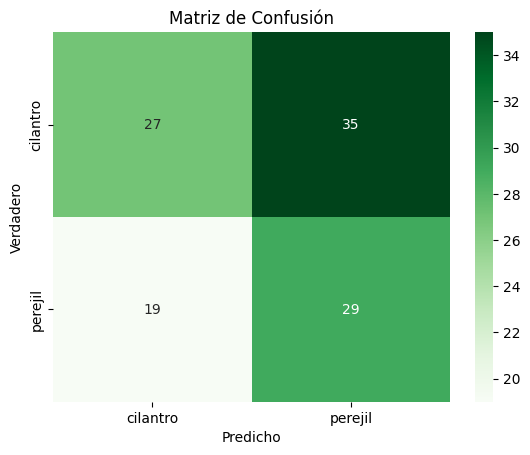

📊 Reporte de clasificación:
              precision    recall  f1-score   support

    cilantro       0.59      0.44      0.50        62
     perejil       0.45      0.60      0.52        48

    accuracy                           0.51       110
   macro avg       0.52      0.52      0.51       110
weighted avg       0.53      0.51      0.51       110



In [31]:
y_true = test.classes
y_pred_probs = model.predict(test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

labels = list(test.class_indices.keys())
cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=labels, yticklabels=labels)
plt.title("Matriz de Confusión")
plt.xlabel("Predicho")
plt.ylabel("Verdadero")
plt.show()

print("📊 Reporte de clasificación:")
print(classification_report(y_true, y_pred, target_names=labels))

## 6. GRÁFICAS 

4/4 [==============================] - 1s 266ms/step - loss: 0.6940 - accuracy: 0.5364


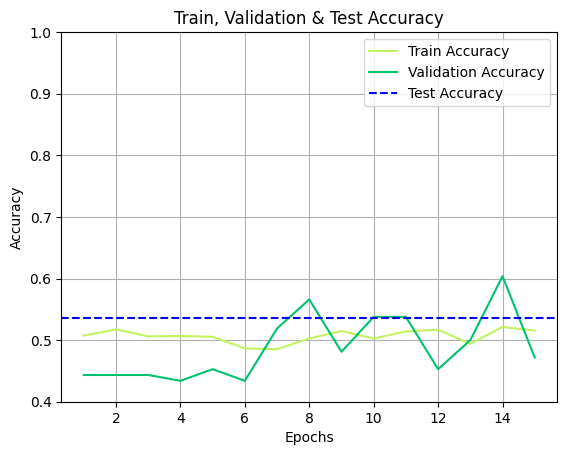

4/4 [==============================] - 4s 1s/step - loss: 0.6993 - accuracy: 0.5182


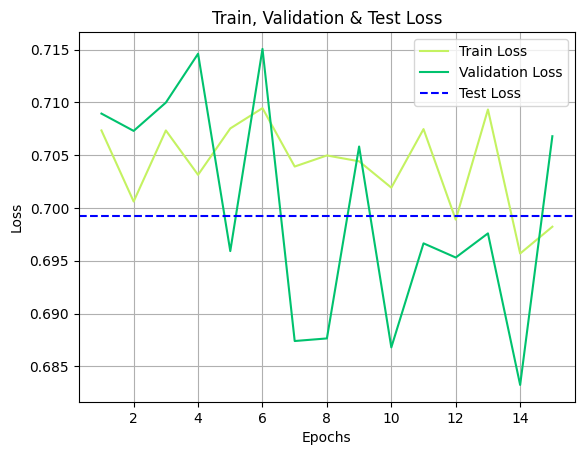

In [32]:
# === Evaluación en test ===
test_loss, test_acc = model.evaluate(test)
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

# === Accuracy Plot ===
plt.figure()
plt.plot(epochs, accuracy, color='#C4F261', label='Train Accuracy')
plt.plot(epochs, val_accuracy, color='#00C26E', label='Validation Accuracy')
plt.axhline(y=test_acc, color='blue', linestyle='--', label='Test Accuracy')
plt.title('Train, Validation & Test Accuracy')
plt.ylim(0.4, 1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# === Loss Plot ===
train_loss = history.history['loss']
val_loss = history.history['val_loss']
test_loss = model.evaluate(test)[0]

plt.figure()
plt.plot(epochs, train_loss, color='#C4F261', label='Train Loss')  
plt.plot(epochs, val_loss, color='#00C26E', label='Validation Loss')     
plt.axhline(y=test_loss, color='blue', linestyle='--', label='Test Loss')
plt.title('Train, Validation & Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


## 7. GUARDAR 

In [33]:
# Option 1: Save without optimizer (for SavedModel)
model.save('modelo_entrenado_inference', save_format='tf', include_optimizer=False)

# Option 2: Save in .keras format (best for Keras 3)
model.save('modelo_entrenado.keras')

INFO:tensorflow:Assets written to: modelo_entrenado_inference/assets


INFO:tensorflow:Assets written to: modelo_entrenado_inference/assets


## 8. CARGAR MODELO

In [34]:
from tensorflow.keras.models import load_model
model = load_model('modelo_entrenado_inference')